# CNN ML Notebook

This notebook will introduce CNN building atop of DNN nodes and will examine how they work.

Then after doing this we will build a variational-auto-encoder for the mnist numerical dataset and examine the different aspects of this dataset up-close.

_Created by Robert Currie (<rob.currie@ed.ac.uk>)_

_Minor edits (and hopefully no errors introduced!) by Tudor Dimofte (<tudor.dimofte@ed.ac.uk>)_


## Before You Begin

**What you need to do:**
- Complete all code cells marked with `## FINISH_ME ##`
- Answer all questions marked with **Q:** in the markdown cells
- Run cells as you complete them to verify your code works

**If you get stuck:**
- Read the hints provided above each problem
- Ask a TA or online for guidance
- Focus on understanding the concepts, not just filling in blanks


## Part 1 2D Sobel filters

This section is about building the 2D Sobel filters and applying them to an input image

## Part 2 PyTorch 2D CNN filters

This section covers building and applying different filters

## Part 3 Building a VAE model

This section is about Building a VAE model using the PyTorch API

## Part 4 Training our VAE with Test/Validate

This section is about Training the VAE model, again using PyTorch, but now with a validation dataset

## Part 5 Load/Save model

This section introduces the load/save model

## Part 6 Examining the VAE Latent Space

This section is about taking the trained VAE model and examining the structure of the latent-space distribution


## Assessment

This notebook will form the entire second AGQ Computing homework set, due on your GitHub by 9:30am on Friday, 13 January. Despite the due date, it is recommended that you work through at least some of the notebook early on, so that you can keep up with Weeks 4-5.



| <p align='left'> Title                         | <p align='left'> Parts | <p align='left'> Marks | <p align='left'> Marks awarded |
| ------------------------------------- | ----- | --- | --- |
| <p align='left'> 1. Construct 2D Sobel Filters and apply                   | <p align='left'>  2  | <p align='left'> 1 | |
| <p align='left'> 2. Constructing different sized 2D filters and examine output | <p align='left'>  1  | <p align='left'> 1 | |
| <p align='left'> 3. Building the VAE model                                 | <p align='left'>  3  | <p align='left'> 3 | |
| <p align='left'> 4. Train the VAE model                                    | <p align='left'>  2  | <p align='left'> 2 | |
| <p align='left'> 5. Load/Save a model to disk                              | <p align='left'>  1  | <p align='left'> 1 | |
| <p align='left'> 6. Examine the trained VAE latent space                   | <p align='left'>  2  | <p align='left'> 2 | |
**Total** | | 10 | |


# Part 0

Load the requirements to run the notebook

In [1]:
# TQDM isn't icluded in the agq-env environment by default.
# You can add it to the agq-env environment by using the following command:
!conda install tqdm
!conda install seaborn
# Note: the `!` gets the notebook to run a terminal command.
# An alternative is   !pip install tqdm

Error while loading conda entry point: conda-libmamba-solver (dlopen(/opt/anaconda3/lib/python3.12/site-packages/libmambapy/bindings.cpython-312-darwin.so, 0x0002): Library not loaded: @rpath/libarchive.20.dylib
  Referenced from: <496442DC-0EDE-3705-A2B5-401A4FC0D733> /opt/anaconda3/lib/libmamba.2.0.0.dylib
  Reason: tried: '/opt/anaconda3/lib/libarchive.20.dylib' (no such file), '/opt/anaconda3/lib/python3.12/site-packages/libmambapy/../../../libarchive.20.dylib' (no such file), '/opt/anaconda3/lib/python3.12/site-packages/libmambapy/../../../libarchive.20.dylib' (no such file), '/opt/anaconda3/bin/../lib/libarchive.20.dylib' (no such file), '/opt/anaconda3/bin/../lib/libarchive.20.dylib' (no such file), '/usr/local/lib/libarchive.20.dylib' (no such file), '/usr/lib/libarchive.20.dylib' (no such file, not in dyld cache))

CondaValueError: You have chosen a non-default solver backend (libmamba) but it was not recognized. Choose one of: classic

Error while loading conda entry point: c

In [2]:
%pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [4]:
import os
os.environ["OMP_NUM_THREADS"] = "4"
os.environ["MKL_NUM_THREADS"] = "4"
from itertools import permutations
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import random
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from PIL import Image

torch.set_num_threads(4)


/opt/anaconda3/envs/agq-env/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/envs/agq-env/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <CFED5F8E-EC3F-36FD-AAA3-2C6C7F8D3DD9> /opt/anaconda3/envs/agq-env/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <F33ACD4D-1C10-3F4E-ADEC-717A02BDBB52> /opt/anaconda3/envs/agq-env/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


## Library Imports

Essential libraries for building and training the VAE:

- **`torch`**: Core PyTorch library for tensor operations and neural networks
- **`torchvision`**: Provides datasets (MNIST) and transforms for preprocessing
- **`matplotlib`**: For visualization of images, losses, and latent space
- **`numpy`**: Numerical operations and array manipulation
- **`tqdm`**: Progress bars for training loops


In [5]:
# Reproducibility in Science is critial, in computing it's often just a convenience
_FIXED_SEED=12345
random.seed(_FIXED_SEED)
np.random.seed(_FIXED_SEED)

# This is a connection of globals needed to make everything re-producible
torch.manual_seed(_FIXED_SEED)  # PyTorch CPU

# Ensure reproducibility on Metal (MPS)
if torch.backends.mps.is_available():
    torch.mps.manual_seed(_FIXED_SEED)  # Fix seed for MPS backend

if torch.cuda.is_available():
    torch.cuda.manual_seed(_FIXED_SEED)  # PyTorch GPU (if used)
    torch.cuda.manual_seed_all(_FIXED_SEED)  # If using multi-GPU

    # Ensure deterministic behavior in CUDA operations (if available)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False  # Disable auto-tuner for determinism

## Reproducibility Setup

Setting random seeds ensures experiments are reproducible:

**Why this matters:**
- Neural network training involves randomness (weight initialization, data shuffling, dropout)
- Fixed seeds make results reproducible across runs
- Critical for scientific experiments and debugging

**What we're fixing:**
- Python's `random` module
- NumPy's random number generator
- PyTorch CPU operations
- PyTorch GPU (CUDA) operations if available
- PyTorch MPS (Apple Silicon) if available

**Additional settings:**
- `cudnn.deterministic = True`: Forces deterministic algorithms (may be slower)
- `cudnn.benchmark = False`: Disables auto-tuning (ensures same behavior every run)

# Part 1 Sobel Filters

This short section will walk through using Sobel filters to perform "edge detection" on an input image.

For this you will need to complete the Sobel filters themselves and then apply them to the input image that has been provided and analyze the output.

## 1.1 Lets analyze our input image and convert to grayscale

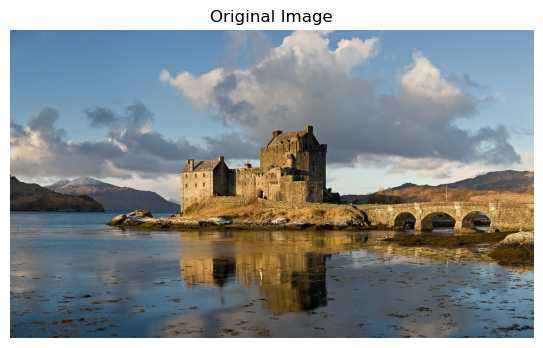

In [6]:
# Load the image using matplotlib's imread
image_path = 'img.png'
image = plt.imread(image_path)  # Reads image as (H, W, C) or (H, W) if grayscale

# First plot our input image for comparison.
plt.figure(figsize=(12, 4))
plt.title('Original Image')
plt.imshow(image.squeeze())
plt.axis('off')
plt.show()

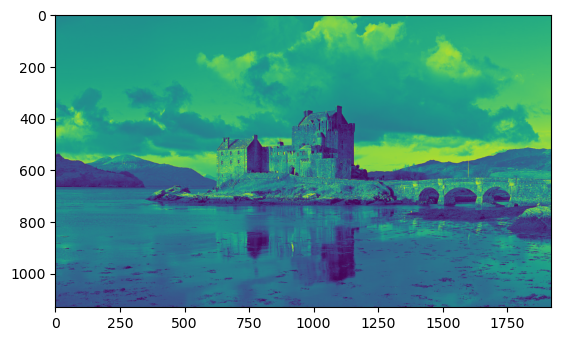

In [7]:
# Convert to grayscale as it's an RGB image

# Currently the shape of the image is image.shape = (H,W,3)
# Replace it with an image (stored in the same variable, "image") whose shape is just (H,W), using the "average method"
#  i.e. each new entry image[h,w] is the average of the three old ones (image[h,w,0]+image[h,w,1]+image[h,w,2])/3
#  (Try to use simple numpy commands to do this.)
image =image.mean(axis=2)
plt.imshow(image.squeeze())


In [8]:
# Optional: investigate image.min() and image.max().
# The image should be normalized so that the values of each pixel lie between 0 and 1.
# If that's not true (e.g. sometimes they run from 0 to 255), normalize (rescale) to get back to the [0,1] range.

## 1.2 Construct the Sobel filters

The kernels Gx and Gy as covered in the lecture:
```
      _               _                   _                _
     |                 |                 |                  |
     | 1.0   0.0  -1.0 |                 |  1.0   2.0   1.0 |
Gx = | 2.0   0.0  -2.0 |    and     Gy = |  0.0   0.0   0.0 |
     | 1.0   0.0  -1.0 |                 | -1.0  -2.0  -1.0 |
     |_               _|                 |_                _|
```

In [9]:
# Convert to a torch tensor, and add batch and channel dimensions (1, 1, H, W)
image_tensor = torch.tensor(image, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
print(image_tensor.shape)
Gx = [ [1,0,-1],[2,0,-2],[1,0,-1]] 
Gy = [ [1,2,1],[0,0,0],[-1,-2,-1] ]

# Define Sobel kernels
sobel_kernel_x = torch.tensor(Gx, dtype=torch.float32).view(1,1,3, 3)

sobel_kernel_y = torch.tensor(Gy, dtype=torch.float32).view(1,1, 3, 3)

torch.Size([1, 1, 1130, 1920])


## 1.3 Apply Sobel and plot the result

NB:
When plotting the result of applying a filter it's always best to plot the RMS of the data.

In [10]:
# Apply Sobel filters using convolution
edges_x = F.conv2d(image_tensor, sobel_kernel_x, padding=1)
edges_y = F.conv2d(image_tensor, sobel_kernel_y, padding=1)

In [11]:
# Combine edges to get the gradient magnitude
edges = torch.sqrt(edges_x**2 + edges_y**2)

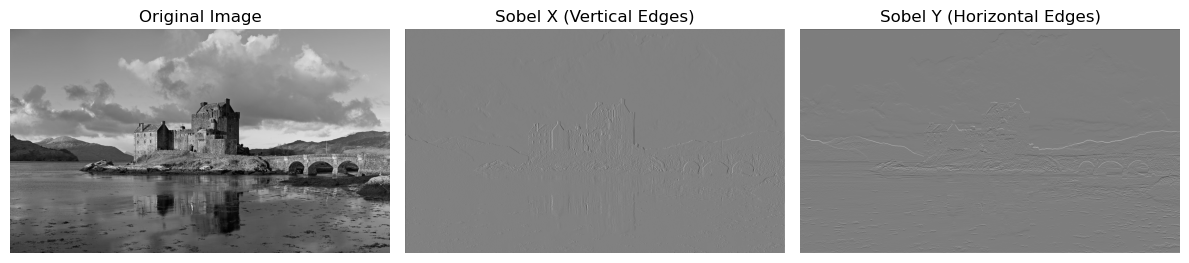

In [12]:
# Plot the original and edge-detected images
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(image_tensor.squeeze().numpy(), cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Sobel X (Vertical Edges)')
plt.imshow(edges_x.squeeze(),cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Sobel Y (Horizontal Edges)')
plt.imshow(edges_y.squeeze(),cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

# Part 2 Understanding the PyTorch 2D CNN

First we'll load the mnist numerical dataset, construct some 2D CNN and see if we understand the results.

##  Part 2.1 Load the mnist dataset, this-time using PyTorch transforms

In [13]:
# Data Preparation
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(size=28, scale=(0.9, 1.1)),  # Randomly crop and resize to 28x28
    transforms.RandomRotation(degrees=3),  # Randomly rotate images by ±3 degrees
    transforms.ToTensor(),
#    transforms.Lambda(lambda t: 1.0 - t),  # Invert image (white<->black)
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
#    transforms.Lambda(lambda t: 1.0 - t),  # Invert image (white<->black)
])

### Data Augmentation and Preprocessing

**Training transforms (with augmentation):**
- `RandomResizedCrop`: Randomly crops and resizes images (scale 90-110%)
  - Helps model learn to recognize digits at different scales and positions
- `RandomRotation`: Rotates images by ±3 degrees
  - Makes model robust to slight rotations
- `ToTensor`: Converts PIL images to PyTorch tensors and scales to [0, 1]
- `Lambda (optional)`: Can invert images (swap black/white) if needed

**Test transforms (no augmentation):**
- Only applies `ToTensor` conversion
- No random augmentation for fair evaluation

**Why augmentation only on training:**
- Increases effective dataset size
- Improves generalization
- Test/validation need consistent, unaugmented data for reliable metrics

**Important:** Never divide by 255 after `ToTensor()` — it already normalizes to [0, 1]!

In [14]:
# Load full training MNIST dataset
dataset = datasets.MNIST(root='./data', train=True, transform=train_transform, download=True)
# Load Test Set
test_dataset = datasets.MNIST(root='./data', train=False, transform=test_transform, download=True)

# Split the training dataset into 90% train, 10% validation
train_size = 0.9
val_size = 0.1
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

## Part 2.2 Create some Conv 2D CNN and apply them to some example inputs

First, select a random image from the `train_dataset` and keep a reference to just the image `(1, image_shape)`

In [15]:
random_idx = random.randint(0, len(train_dataset) - 1)  # Select a random image
image, label = train_dataset[random_idx]  # Random MNIST image

# Add batch and channel dimensions for Conv2d (1, 1, 28, 28)
input_image = image.unsqueeze(0)
print(input_image.shape)  # Shape: (1, 1, 28, 28)

torch.Size([1, 1, 28, 28])


Now we want to apply different kernel configurations to this image and see the impact that they have on the image.

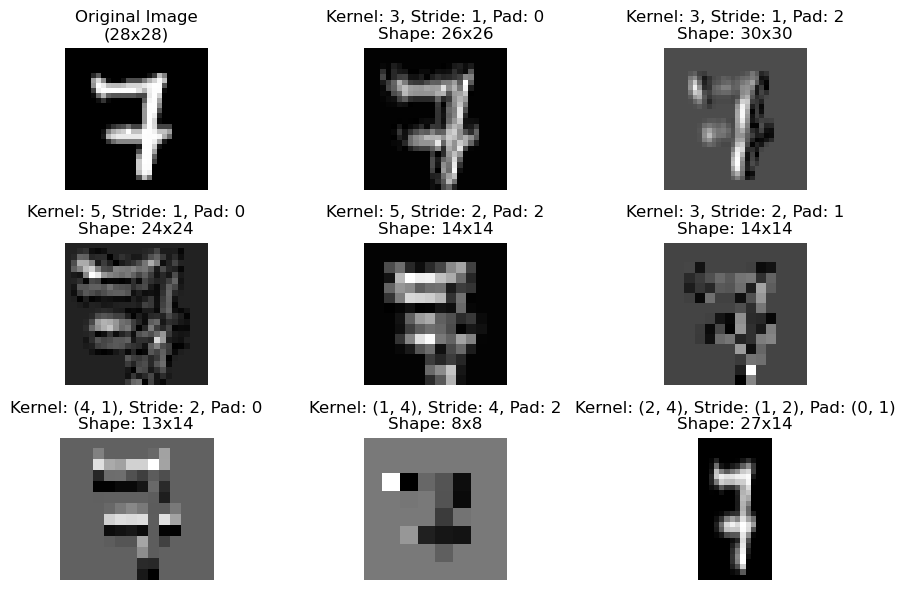

In [16]:
# Function to Apply Convolution with Different Configs
def apply_conv(input_image, kernel_size, stride, padding):
    conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=kernel_size, stride=stride, padding=padding)
    output = conv(input_image)
    return output

# 9 example different Configurations
configs = [
    {"kernel_size": 3, "stride": 1, "padding": 0},
    {"kernel_size": 3, "stride": 1, "padding": 2},
    {"kernel_size": 5, "stride": 1, "padding": 0},
    {"kernel_size": 5, "stride": 2, "padding": 2},
    {"kernel_size": 3, "stride": 2, "padding": 1},
    {"kernel_size": (4,1), "stride": 2, "padding": 0},
    {"kernel_size": (1,4), "stride": 4, "padding": 2},
    {"kernel_size": (2,4), "stride": (1,2), "padding": (0,1)},
]

# Plot Input Image
plt.figure(figsize=(10, 6))
# Want to plot the result rom applying all different configurations above to the input image
plt.subplot(3, 3, 1)
plt.imshow(image.squeeze(), cmap='gray')
plt.title(f"Original Image\n(28x28)")
plt.axis('off')

# Apply Configurations and Plot Outputs
for i, cfg in enumerate(configs):

    output = apply_conv(input_image,cfg['kernel_size'],cfg['stride'],cfg['padding'])
    
    output_shape = output.shape  # Shape: (1, 1, H_out, W_out)

    plt.subplot(3, 3, i+2)
    plt.imshow(torch.sqrt(output**2).detach().squeeze(), cmap='gray')
    plt.title(f"Kernel: {cfg['kernel_size']}, Stride: {cfg['stride']}, Pad: {cfg['padding']}\nShape: {output_shape[2]}x{output_shape[3]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

# Part 3 Construct our data loaders and Variational Auto-Encoder model

Our VAE model is designed to encode information from our images into a low-dimensional latent space.

### Hyperparameters Configuration

These hyperparameters control the VAE training process:
- **`batch_size`**: Number of images processed together (larger = faster but more memory)
- **`latent_dim`**: Dimensionality of the compressed latent space representation
- **`epochs`**: Number of complete passes through the training data
- **`learning_rate`**: Step size for optimizer (controls how fast the model learns)
- **`vae_base_model_dim`**: The _base_ dimension of the CNN VAE model which we're looking to build

In [17]:
# These aren't needed until later but it's common/very-good practice to define globals at the top of any file/playbook

# Hyperparameters
batch_size = 64
latent_dim = 16
epochs = 100
learning_rate = 1e-2

# Model specific hyperparameters
vae_base_model_dim = 4

## Part 3.1 Construct our data loaders

In [18]:
# Create DataLoaders for train and validate
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Data Loading and Preparation

Here we load the MNIST dataset and split it into training, validation, and test sets:
- **Training set** (90% of original training data): Used to train the model
- **Validation set** (10% of original training data): Used to tune hyperparameters and detect overfitting
- **Test set** (official MNIST test set): Final evaluation of model performance

We need to ensure we have independent data for validation.

## Part 3.2 Construct our Variational Auto-Encoder class

Our Auto-Encoder class has several key features which we want to demonstrate.

1. Decreasing dimension when Encoding information into latent-space.
2. Increasing dimension when Decoding from latent-space.
3. Symmetry between our encoder and decoder to help model training.
4. Fixed Latent-Space dimension
5. Weights initialized using 'sensible' defaults
6. Use of the 'SiLU' https://pytorch.org/docs/stable/generated/torch.nn.SiLU.html and related 'GELU' https://docs.pytorch.org/docs/stable/generated/torch.nn.GELU.html activation functions

Our encoder needs to output the value of the input image encoded into this latent-space.


### 3.2.0 Build our Encoder

We want to start from 1x28x28 and then

0. apply a convolution filter that preserves the size, getting 1x28x28 again
1. apply a filter that decreases to 14x14, but makes vae_base_model_dim copies, hence (vae_base_model_dim)x14x14
2. then decrease again to (vae_base_model_dim x2)x7x7
3. and then take these entries and pass them through a linear DNN layer to a vector of size 128.
Then finally we take this output and encode the final value onto our latent-space parameters via mu/logvar.

It's common to use kernels of size 3 when sampling but not up/down-scaling and more common to use larger filters such as 4, 5,... when up/down-sampling to capture more information.

**Q**: Fill in the following with the parameters of the convolution kernels that would be needed to achieve the steps above:

0. input=1, output=1, kernel=3, stride=1, padding=1
1. input=1, output=(vae_base_model_dim), kernel=5, stride= **?**, padding= **?**
2. input=(vae_base_model_dim), output=(vae_base_model_dim x2), kernel=5, stride= **?**, padding= **?**
3. (vae_base_model_dim x2)x7x7 -> 128

Below, we will *not* increase the stride in order to down-sample. Rather, we will keep the stride equal to 1 for convolution filters, and then use average pooling to down-sample.

### Encoder Architecture

The encoder compresses 28×28 MNIST images into a low-dimensional latent representation:

**Architecture flow:**
1. **Conv2d + AvgPool2d** layers progressively downsample spatial dimensions
   - Input: 1×28×28 → 4×14×14 → 8×7×7    (for vae_base_model_dim = 4)
2. **Flatten** converts 2D feature maps to 1D vector
3. **Fully connected layers** project to latent space parameters (μ and log σ²)

**Key design choices:**
- MaxPool2d for downsampling (instead of strided convolutions) preserves important features
- Outputs both `mu` and `logvar` for the latent distribution
- Weight initialization (Kaiming for conv, Xavier for linear) ensures stable training

In [19]:
# CNN Encoder with SiLU/GELU and Batch Normalization
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()

        # conv0 is used by layer1
        self.conv0 = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1)

        # conv1, pool1, and bn1 are used by layer2
        self.conv1 = nn.Conv2d(1, vae_base_model_dim, kernel_size=5, stride=1, padding=2) 
        self.pool1 = nn.AvgPool2d(2, stride = 2)
        self.bn1 = nn.BatchNorm2d(vae_base_model_dim)

        # Add another layer to scale down further
        # Define self.conv2, self.pool2, self.bn2 in a similar way
        ## FINISH_ME ##
        self.conv2 = nn.Conv2d(vae_base_model_dim, vae_base_model_dim*2, kernel_size=5, stride=1, padding=2) 
        self.pool2 = nn.AvgPool2d(2, stride = 2)
        self.bn2 = nn.BatchNorm2d(vae_base_model_dim*2)

        # fc1 'projects' from filtered data to a 128-dimensional linear space
        self.fc1 = nn.Linear(vae_base_model_dim*2 * 7 * 7, 128)

        # fc_mu and fc_logvar are needed to use the re-param trick later
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_logvar = nn.Linear(128, latent_dim)

        # Lets make sure the model is initialized better than random
        self._initialize_weights()

    def forward(self, x):
        # Layer 1 we're not down-sampling, we're performing feature extraction
        x = F.gelu(self.conv0(x))
        # Layer 2 we want to down-sample, reducing data to next layer by 50%
        x = self.bn1(self.conv1(x))
        x = F.gelu(self.pool1(x))
        # Layer 3 we're down-sampling again
        x = self.bn2(self.conv2(x))
        x = F.gelu(self.pool2(x))

        # This is the equivalent of re-sizing the data flowing through the model
        # This preserves the dim x[0] which is needed to preserve the batch-structure
        x = x.view(x.size(0), -1)

        # This now projects the flattened data to 128-dim
        x = F.gelu(self.fc1(x))

        # This finally projects down from 128 -> latent-dim
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def _initialize_weights(self):
        # This iterates through all PyTorch objects created within this class
        ## The mechanism for this is advanced but is made available by Python 'magic'
        for m in self.modules():
            # If we find a Conv2D class within our module, make sure we initialize this better
            # https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_normal_
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            # If we find a Linear class lets initialize the parameters using xavier
            # https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.xavier_uniform_
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

#### Now we test our Encoder

We want to pass a random _`image`_ to our model.

We then create an instance of our Encoder.

Then we see if the model returns `mu` and `logvar` from the model with the correct dimension.

In [20]:
# Generate a batch of random noise images (e.g., with batch_size=4)

batch_size = 4
noise = torch.rand(batch_size,1,28,28).to('cpu')  # values in [0, 1]

# Creat an instance of the encoder, and set it to evaluation mode
encoder = Encoder(latent_dim=16)
encoder.eval()

# Forward pass through encoder
with torch.no_grad():
    mu, logvar = encoder(noise)

print("mu shape:", mu.shape)
print("logvar shape:", logvar.shape)

mu shape: torch.Size([4, 16])
logvar shape: torch.Size([4, 16])


### 3.2.1 Build our Decoder

Starting from our latent-space we first need to project up to 8x7x7 and then using filters, up-scale to 4x14x14, 1x28x28 then finally use an additional filter preserving the dimension 1x28x28.

We want to make our decoder symmetrical to our encoder but in reverse. This helps with model stability during training.


### Decoder Architecture

The decoder reconstructs images from the latent space representation:

**Architecture flow:**
1. **Fully connected layers** project from latent space to spatial features
2. **Reshape** to 2D feature maps (32×7×7)
3. **Upsample + Conv2d** layers progressively increase spatial resolution
   - 8×7×7 → 4×14×14 → 1×28×28
4. **Sigmoid activation** ensures output pixels are in [0, 1] range

**Key design choices:**
- `nn.functional.interpolate` (linear interpolation) + Conv2d for upsampling avoids checkerboard artifacts
- Alternative: ConvTranspose2d can also be used but requires careful tuning
- Symmetric to encoder (mirrors the compression path)
- Sigmoid output matches MNIST's normalized pixel values

In [21]:
# DNN Decoder with LeakyReLU and Batch Normalization
class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()

        # fc1 projects up from the Latent-Space to 128-dim
        self.fc1 = nn.Linear(latent_dim, 128)

        # fc2 projects from 128-dim to model input
        self.fc2 = nn.Linear(128, vae_base_model_dim*2 * 7 * 7)

        def interpolate(x, scale_factor=2, mode='bilinear'):
            return F.interpolate(x, scale_factor=scale_factor, mode=mode)

        # deconv0 & bn3 up-sample from Latent-Space dist
        # We use interpolate, Conv2d, and BatchNorm2d
        self.upsample0 = interpolate  # 7x7 -> 14x14
        self.deconv0 = nn.Conv2d(vae_base_model_dim * 2, vae_base_model_dim, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(vae_base_model_dim)

        

        # Add a second up-sampling layer
        # Define self.upsample1, self.deconv1, self.bn4
        self.upsample1 = interpolate 
        self.deconv1 = nn.Conv2d(vae_base_model_dim, 1, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(1)
        

        # deonv2 peforms the opposite of feature extraction, identifying key features from the up-scaling
        self.deconv2 = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1)

        # Lets make sure the model is initialized better than random
        self._initialize_weights()

    def forward(self, z):
        # Lets project from Latent-Space to 128-dim
        x = F.gelu(self.fc1(z))
        # Lets project from 128-dim to up-scale filters
        x = F.gelu(self.fc2(x))

        # This is the equivalent to the opposite of the 'flatten' reize in the encoder
        x = x.view(x.size(0), vae_base_model_dim*2, 7, 7)

        # This up-scales from the Latent-Space projection to a larger image
        x = F.gelu(self.bn3(self.deconv0(x)))
        x = self.upsample0(x)
        # This up-scales again to give us output image sized data-streams
        x = F.gelu(self.bn4(self.deconv1(x)))
        x = self.upsample1(x)

        # This is the final 'projection' layer which extracts key features and makes an output image
        x = torch.sigmoid(self.deconv2(x))
        return x

    def _initialize_weights(self):
        # This iterates through all PyTorch objects created within this class
        ## The mechanism for this is advanced but is made available by Python 'magic'
        for m in self.modules():
            # If we find a Conv2D class within our module, make sure we initialize this better
            # https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_normal_
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            # If we find a Linear class lets initialize the parameters using xavier
            # https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.xavier_uniform_
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

#### Now we test our Decoder

Make a random _`latent-vector`_ of the same size of our expected input. (i.e. the same dimension as the `mu` output from the encoder)

Then create an instance of our Decoder Class.

Evaluate our model to make sure it outputs the correct image dimension.

In [22]:
# Generate a batch of random latent vectors
z = torch.rand(1,16).to('cpu')

# Create an instance of the Decoder Class, and set it to evaluation mode
decoder = Decoder(latent_dim=16)
decoder.eval()

# Forward pass through the Decoder
with torch.no_grad():
    output = decoder(z)

print("Decoder output shape:", output.shape)

Decoder output shape: torch.Size([1, 1, 28, 28])


### 3.2.3 Build the final VAE model

The VAE model itself is quite short. We just want to programatically 'connect' the Encoder and Decoder graphs through their latent-space and return the outputs needed by our loss function(s).

### The Reparameterization Trick

This is a critical component of VAEs that makes backpropagation possible through stochastic sampling:

**Why it's needed:**
- The VAE needs to sample from the latent distribution during training
- But sampling is a non-differentiable operation (can't compute gradients through random sampling)

**How it works:**
- Instead of sampling `z ~ N(μ, σ²)` directly
- We sample `ε ~ N(0, 1)` and compute `z = μ + σ * ε`
- This separates the randomness (ε) from the learnable parameters (μ, σ)
- Gradients can now flow through μ and σ while ε remains random

**Formula:** `z = μ + exp(0.5 * log(σ²)) * ε`

In [23]:
# Variational Autoencoder (VAE)
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()

        # Our VAE needs an Encoder and Decoder
        # Both need to be constructed with knowledge of the required latent-dim
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

        self._initialize_weights()

    def _initialize_weights(self):
        self.encoder._initialize_weights()
        self.decoder._initialize_weights()

    # Reparameterization Trick
    @staticmethod
    def reparameterize(mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        # The encoder returns mu and sigma(logvar) of our distribtuion in LS
        mu, logvar = self.encoder(x)
        # We now want to re-parameterize to a single vector in LS
        z = VAE.reparameterize(mu, logvar)
        # The decoder is able to now take the single vector to re-construct an image
        x_recon = self.decoder(z)
        # To train the model we need to return the final value
        # AND intermediate values from the construction of our LS
        return x_recon, mu, logvar

In [24]:
# Generate a batch of random noise images (e.g., batch_size=4)
batch_size = 4
noise = torch.rand(batch_size,1,28,28).to('cpu')  # values in [0, 1]

# Create an instance of the VAE, put it in evalution mode, and evaluate it on the random sample
vae = VAE(latent_dim=16)
vae.eval()

with torch.no_grad():
    x_recon,mu, logvar = vae(noise)

print("Reconstructed image shape:", x_recon.shape)
print("mu shape:", mu.shape)

Reconstructed image shape: torch.Size([4, 1, 28, 28])
mu shape: torch.Size([4, 16])


## 3.3 Defining the Model Loss

The total training loss from this model is the linear combination of the KL-divergence and the Reconstruction loss of the images themselves.

The Reconstruction loss in this case is simply defined as the F.mse_loss https://pytorch.org/docs/stable/generated/torch.nn.functional.mse_loss.html

### VAE Loss Function

The VAE loss combines two components to achieve both reconstruction and regularization:

**1. Reconstruction Loss** (MSE or BCE):
- Measures how well the decoder reconstructs the input
- MSE: Good for continuous-valued data like images
- Lower loss = better reconstruction quality

**2. KL Divergence Loss**:
- Regularizes the latent space to follow a standard normal distribution N(0,1)
- Formula: `-0.5 * Σ(1 + log(σ²) - μ² - σ²)`
- Prevents the encoder from "cheating" by using arbitrary encodings
- Ensures smooth, continuous latent space (nearby points = similar images)

**Total Loss** = Reconstruction Loss + KL Divergence

**Why both are needed:**
- Reconstruction alone → model ignores latent space structure
- KL alone → model ignores input images
- Together → meaningful, structured latent representations

In [25]:
# Loss Function: Reconstruction Loss + KL Divergence
def loss_function(x_recon, x, mu, logvar):
    # The loss function relies on Model Output, Truth, mu and sigma

    # First part of the loss is simply how 'bad' our output images are compared to 'truth'
    recon_loss = F.mse_loss(x_recon, x, reduction='sum')

    # We want to make sure our Latent-Space is encoded down to a 'Probability Space'
    # This means we want to calculate the kl_loss of our LS-vector distribution compared to a sampled normalized probaility
    kl_loss = -0.05 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + kl_loss, recon_loss

### Training Loop with Early Stopping

This training loop includes several important features:

**Early Stopping:**
- Monitors validation loss and stops if no improvement for `patience` epochs
- Prevents overfitting and saves training time
- Saves the best model based on validation performance

**Warmup Period:**
- Initial epochs where early stopping is disabled
- Allows the model to stabilize before strict monitoring begins

**Progress Tracking:**
- Uses `tqdm` for visual progress bars
- Prints losses in scientific notation for easy comparison
- Tracks both training and validation losses per epoch

**Best Model Checkpointing:**
- Automatically saves the model whenever validation loss improves
- Ensures you can recover the best model even if training continues past the optimal point

# Part 4 Training our model

As with our Classifier model we need to train our model to do something useful and extract information from the dataset

## Part 4.1 training pre-requisites

In [26]:
# Training Loop
device = torch.device("cpu") # As with Week 1 if you have access to anything 'non-cpu' I recommend using it here(!)
latent_dim = 16
learning_rate = 1e-3
# To train our model we need to first construct it, this means we can make a decision here on the latent-dim of the model
vae = VAE(latent_dim).to(device)

# To train the model we constructed we need to let the optimizer know about it
optimizer = optim.Adam(vae.parameters(), lr=learning_rate, weight_decay=0.001)

### Model Parameter Count

To understanding model complexity, where are the free parameters in our full VAE?

This should show a symmetry between the Encoder/Decoder components of the full VAE so that model will train correctly.

In [27]:
# Count trainable parameters
total_params = sum(p.numel() for p in vae.parameters())
trainable_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"\nParameter breakdown by layer:")
print("-" * 60)
for name, param in vae.named_parameters():
    if param.requires_grad:
        print(f"{name:40s} {param.numel():>10,} params")
print("-" * 60)
print(f"{'TOTAL':40s} {trainable_params:>10,} params")

Total parameters: 108,471
Trainable parameters: 108,471

Parameter breakdown by layer:
------------------------------------------------------------
encoder.conv0.weight                              9 params
encoder.conv0.bias                                1 params
encoder.conv1.weight                            100 params
encoder.conv1.bias                                4 params
encoder.bn1.weight                                4 params
encoder.bn1.bias                                  4 params
encoder.conv2.weight                            800 params
encoder.conv2.bias                                8 params
encoder.bn2.weight                                8 params
encoder.bn2.bias                                  8 params
encoder.fc1.weight                           50,176 params
encoder.fc1.bias                                128 params
encoder.fc_mu.weight                          2,048 params
encoder.fc_mu.bias                               16 params
encoder.fc_logvar.weight  

### Device Configuration and Model Initialization

**Device selection:**
- GPU training is 10-100x faster for neural networks

**Model initialization:**
- Creates the VAE with specified `latent_dim`
- Moves model to the selected device (GPU/CPU)
- Sets up Adam optimizer with learning rate and weight decay

**Adam optimizer:**
- Adaptive learning rate method (generally better than SGD for deep learning)
- `lr`: Base learning rate (controls step size)
- `weight_decay`: L2 regularization (prevents overfitting)

## Part 4.2 Our training Loop

It's good to prove that your model trains as expected. However the computational power required to train a proper model for this problem is quite expensive. (30min on a decent GPU or more!)

With that in mind, feel free to only train over 2-3 epochs to demonstrate that your model is indeed reducing in loss per-epoch and compare the raw train and validation losses in the next step

In [28]:
def train_epoch(model, dataloader, optimizer):
    model.train()
    train_loss = 0
    for data, _ in tqdm(dataloader):
        data = data.to(device)

        optimizer.zero_grad()
        x_recon,mu,logvar =model(data)
        loss,_ = loss_function(x_recon,data,mu,logvar)

        loss.backward()
        optimizer.step()

        train_loss+= loss.item()
        
    avg_loss = train_loss / len(dataloader.dataset)
    model.eval()
    return avg_loss

In [29]:
def validate_epoch(model, dataloader):
    model.eval()
    val_loss = 0
    for data, _ in tqdm(dataloader):
        data = data.to(device)
        
        x_recon, mu, logvar = model(data)
        loss, _ = loss_function(x_recon, data, mu, logvar)

        val_loss += loss.item()
        
    avg_loss = val_loss / len(dataloader.dataset)
    return avg_loss

In [30]:
# Initialize variables for early stopping
best_val_loss, avg_val_loss = float('inf'), float('inf')
patience = 5  # Number of epochs to wait for improvement
epochs_no_improve = 0
warmup_epochs = 10
best_model_path = "best_vae_model.pth"

def early_stopping_check():
    global best_val_loss, epochs_no_improve, avg_val_loss, warmup_epochs

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0  # Reset counter if improvement
        # Save the best model
        torch.save(vae.state_dict(), best_model_path)
    else:
        epochs_no_improve += 1  # Increment counter if no improvement

    if warmup_epochs > 0:
        warmup_epochs -= 1
        return False  # Skip early stopping during warm-up

    # Check if early stopping condition is met
    if epochs_no_improve == patience:
        return True
    return False


In [ ]:
# We want to track the training loss and the loss from our validation dataset
train_losses = []
val_losses = []

In [32]:
# Loop over all epochs
for epoch in range(epochs):

    if early_stopping_check():
        print(f"Early stopping at epoch {epoch+1}")
        break

    train_loss = train_epoch(vae, train_loader, optimizer)

    # Validation Loss
    with torch.no_grad():
        val_loss = validate_epoch(vae, val_loader)

    # We can now calculate the loss per-batch for both data (sub-)sets
    avg_train_loss = train_loss
    avg_val_loss = val_loss
    # Store the values to examine them afterwards
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{epochs}, Avg Train Loss: {avg_train_loss:.4e}, Avg Val Loss: {avg_val_loss:.4e}")


  0%|          | 0/844 [00:00<?, ?it/s]

100%|██████████| 94/94 [00:01<00:00, 49.16it/s]


Epoch 1/100, Avg Train Loss: 6.3386e+01, Avg Val Loss: 2.9093e+01


100%|██████████| 94/94 [00:01<00:00, 60.42it/s]


Epoch 2/100, Avg Train Loss: 2.4840e+01, Avg Val Loss: 2.1418e+01


100%|██████████| 94/94 [00:01<00:00, 49.34it/s]


Epoch 3/100, Avg Train Loss: 1.9394e+01, Avg Val Loss: 1.7678e+01


100%|██████████| 94/94 [00:01<00:00, 61.81it/s]


Epoch 4/100, Avg Train Loss: 1.6627e+01, Avg Val Loss: 1.5563e+01


100%|██████████| 94/94 [00:01<00:00, 59.72it/s]


Epoch 5/100, Avg Train Loss: 1.5130e+01, Avg Val Loss: 1.4848e+01


100%|██████████| 94/94 [00:02<00:00, 43.05it/s]


Epoch 6/100, Avg Train Loss: 1.4267e+01, Avg Val Loss: 1.3812e+01


100%|██████████| 94/94 [00:01<00:00, 55.07it/s]


Epoch 7/100, Avg Train Loss: 1.3701e+01, Avg Val Loss: 1.3393e+01


100%|██████████| 94/94 [00:01<00:00, 64.45it/s]


Epoch 8/100, Avg Train Loss: 1.3306e+01, Avg Val Loss: 1.3113e+01


100%|██████████| 94/94 [00:02<00:00, 33.57it/s]


Epoch 9/100, Avg Train Loss: 1.3035e+01, Avg Val Loss: 1.2789e+01


100%|██████████| 94/94 [00:01<00:00, 62.15it/s]


Epoch 10/100, Avg Train Loss: 1.2759e+01, Avg Val Loss: 1.2710e+01


100%|██████████| 94/94 [00:01<00:00, 65.38it/s]


Epoch 11/100, Avg Train Loss: 1.2513e+01, Avg Val Loss: 1.2381e+01


100%|██████████| 94/94 [00:02<00:00, 41.17it/s]


Epoch 12/100, Avg Train Loss: 1.2323e+01, Avg Val Loss: 1.2137e+01


100%|██████████| 94/94 [00:02<00:00, 45.06it/s]


Epoch 13/100, Avg Train Loss: 1.2190e+01, Avg Val Loss: 1.2183e+01


100%|██████████| 94/94 [00:01<00:00, 59.14it/s]


Epoch 14/100, Avg Train Loss: 1.2025e+01, Avg Val Loss: 1.1981e+01


100%|██████████| 94/94 [00:01<00:00, 62.58it/s]


Epoch 15/100, Avg Train Loss: 1.1897e+01, Avg Val Loss: 1.1859e+01


100%|██████████| 94/94 [00:01<00:00, 62.23it/s]


Epoch 16/100, Avg Train Loss: 1.1798e+01, Avg Val Loss: 1.1723e+01


100%|██████████| 94/94 [00:01<00:00, 63.06it/s]


Epoch 17/100, Avg Train Loss: 1.1703e+01, Avg Val Loss: 1.1670e+01


100%|██████████| 94/94 [00:02<00:00, 40.75it/s]


Epoch 18/100, Avg Train Loss: 1.1627e+01, Avg Val Loss: 1.1616e+01


100%|██████████| 94/94 [00:02<00:00, 46.39it/s]


Epoch 19/100, Avg Train Loss: 1.1545e+01, Avg Val Loss: 1.1414e+01


100%|██████████| 94/94 [00:02<00:00, 39.96it/s]


Epoch 20/100, Avg Train Loss: 1.1484e+01, Avg Val Loss: 1.1435e+01


100%|██████████| 94/94 [00:01<00:00, 53.61it/s]


Epoch 21/100, Avg Train Loss: 1.1425e+01, Avg Val Loss: 1.1411e+01


100%|██████████| 94/94 [00:01<00:00, 65.64it/s]


Epoch 22/100, Avg Train Loss: 1.1372e+01, Avg Val Loss: 1.1347e+01


100%|██████████| 94/94 [00:01<00:00, 62.53it/s]


Epoch 23/100, Avg Train Loss: 1.1302e+01, Avg Val Loss: 1.1596e+01


100%|██████████| 94/94 [00:01<00:00, 51.89it/s]


Epoch 24/100, Avg Train Loss: 1.1276e+01, Avg Val Loss: 1.1234e+01


100%|██████████| 94/94 [00:01<00:00, 65.15it/s]


Epoch 25/100, Avg Train Loss: 1.1213e+01, Avg Val Loss: 1.1256e+01


100%|██████████| 94/94 [00:02<00:00, 38.37it/s]


Epoch 26/100, Avg Train Loss: 1.1172e+01, Avg Val Loss: 1.1163e+01


100%|██████████| 94/94 [00:01<00:00, 58.68it/s]


Epoch 27/100, Avg Train Loss: 1.1142e+01, Avg Val Loss: 1.1070e+01


100%|██████████| 94/94 [00:01<00:00, 60.01it/s]


Epoch 28/100, Avg Train Loss: 1.1089e+01, Avg Val Loss: 1.1091e+01


100%|██████████| 94/94 [00:01<00:00, 60.59it/s]


Epoch 29/100, Avg Train Loss: 1.1072e+01, Avg Val Loss: 1.1015e+01


100%|██████████| 94/94 [00:01<00:00, 58.19it/s]


Epoch 30/100, Avg Train Loss: 1.1025e+01, Avg Val Loss: 1.1018e+01


100%|██████████| 94/94 [00:02<00:00, 41.13it/s]


Epoch 31/100, Avg Train Loss: 1.0974e+01, Avg Val Loss: 1.0977e+01


100%|██████████| 94/94 [00:01<00:00, 55.61it/s]


Epoch 32/100, Avg Train Loss: 1.0948e+01, Avg Val Loss: 1.0906e+01


100%|██████████| 94/94 [00:01<00:00, 64.04it/s]


Epoch 33/100, Avg Train Loss: 1.0922e+01, Avg Val Loss: 1.0942e+01


100%|██████████| 94/94 [00:01<00:00, 65.46it/s]


Epoch 34/100, Avg Train Loss: 1.0877e+01, Avg Val Loss: 1.0916e+01


100%|██████████| 94/94 [00:01<00:00, 57.43it/s]


Epoch 35/100, Avg Train Loss: 1.0867e+01, Avg Val Loss: 1.0921e+01


100%|██████████| 94/94 [00:01<00:00, 48.86it/s]


Epoch 36/100, Avg Train Loss: 1.0842e+01, Avg Val Loss: 1.0769e+01


100%|██████████| 94/94 [00:02<00:00, 46.12it/s]


Epoch 37/100, Avg Train Loss: 1.0813e+01, Avg Val Loss: 1.0901e+01


100%|██████████| 94/94 [00:02<00:00, 33.71it/s]


Epoch 38/100, Avg Train Loss: 1.0769e+01, Avg Val Loss: 1.0797e+01


100%|██████████| 94/94 [00:03<00:00, 27.75it/s]


Epoch 39/100, Avg Train Loss: 1.0757e+01, Avg Val Loss: 1.0782e+01


100%|██████████| 94/94 [00:01<00:00, 59.34it/s]


Epoch 40/100, Avg Train Loss: 1.0736e+01, Avg Val Loss: 1.0831e+01


100%|██████████| 94/94 [00:01<00:00, 58.60it/s]


Epoch 41/100, Avg Train Loss: 1.0730e+01, Avg Val Loss: 1.0718e+01


100%|██████████| 94/94 [00:01<00:00, 60.71it/s]


Epoch 42/100, Avg Train Loss: 1.0696e+01, Avg Val Loss: 1.0641e+01


100%|██████████| 94/94 [00:01<00:00, 59.81it/s]


Epoch 43/100, Avg Train Loss: 1.0662e+01, Avg Val Loss: 1.0726e+01


100%|██████████| 94/94 [00:01<00:00, 59.85it/s]


Epoch 44/100, Avg Train Loss: 1.0660e+01, Avg Val Loss: 1.0716e+01


100%|██████████| 94/94 [00:01<00:00, 52.37it/s]


Epoch 45/100, Avg Train Loss: 1.0634e+01, Avg Val Loss: 1.0646e+01


100%|██████████| 94/94 [00:02<00:00, 38.83it/s]


Epoch 46/100, Avg Train Loss: 1.0615e+01, Avg Val Loss: 1.0678e+01


100%|██████████| 94/94 [00:01<00:00, 62.83it/s]

Epoch 47/100, Avg Train Loss: 1.0595e+01, Avg Val Loss: 1.0908e+01
Early stopping at epoch 48


In [33]:
import os
os.getcwd()

'/Users/s2704126/Desktop/Course_Computing/AGQ-computing-2026-HW/Week 3'

In [34]:
open("best_vae_model.pth", "rb")


<_io.BufferedReader name='best_vae_model.pth'>

In [35]:
# (Re)load the best model after training
vae.load_state_dict(torch.load(best_model_path))
vae.eval()  # Set the model to evaluation mode

VAE(
  (encoder): Encoder(
    (conv0): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv1): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (bn1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(4, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (bn2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc1): Linear(in_features=392, out_features=128, bias=True)
    (fc_mu): Linear(in_features=128, out_features=16, bias=True)
    (fc_logvar): Linear(in_features=128, out_features=16, bias=True)
  )
  (decoder): Decoder(
    (fc1): Linear(in_features=16, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=392, bias=True)
    (deconv0): Conv2d(8, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn3): Bat

## Part 4.3 Plot the losses from our training

This allows us to make a statement about whether our model has over-trained or under-trained.

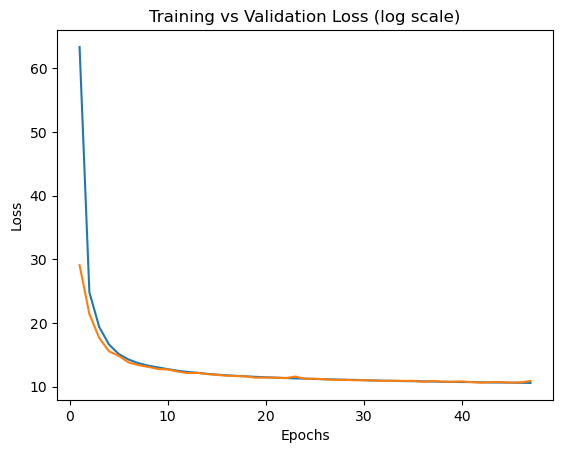

In [36]:
# Plot Training vs Validation Loss
epochs_ran=range(1,len(train_losses)+1)

plt.figure()
plt.plot(epochs_ran,train_losses,label="Training loss")
plt.plot(epochs_ran,val_losses,label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
#plt.yscale("log")
plt.title("Training vs Validation Loss (log scale)")
plt.show()


### Training vs Validation Loss Analysis

This plot helps diagnose model performance:

**What to look for:**
- **Both decreasing:** Model is learning effectively
- **Train < Val, both converging:** Normal, healthy training
- **Train << Val, diverging:** Overfitting (model memorizing training data)
- **Both high, not decreasing:** Underfitting (model too simple or learning rate issues)

**Log scale:**
- Makes it easier to see patterns when losses span multiple orders of magnitude
- Common for VAE losses which can start very high and decrease rapidly

## Part 4.4 Examine the model performance

We want to visualize what the output from our model is based on inputs

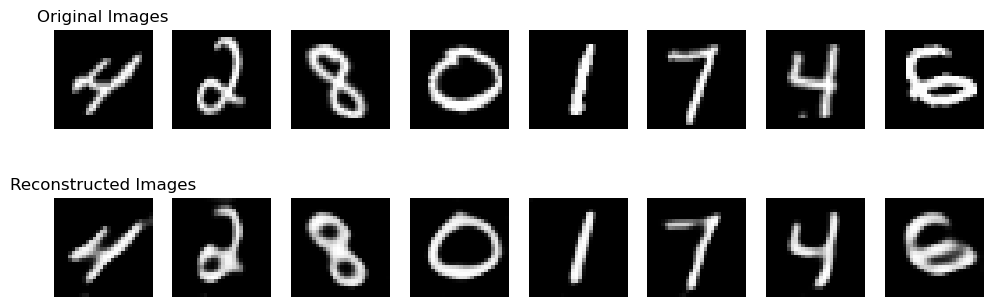

In [37]:
# Show Input vs Reconstructed Images
vae.eval()
with torch.no_grad():
    sample_data, _ = next(iter(train_loader))
    sample_data = sample_data[:8].to(device)  # Select 8 images
    reconstructed, _, _ = vae(sample_data)

# Convert to CPU for visualization
sample_data = sample_data.cpu()
reconstructed = reconstructed.cpu()

# Plot Input vs Output for the 8 images
fig, axes = plt.subplots(2, 8, figsize=(12, 4))
for i in range(8):
    axes[0,i].imshow(sample_data[i,0],cmap="gray")
    axes[0,i].axis("off")

    axes[1,i].imshow(reconstructed[i,0],cmap="gray")
    axes[1,i].axis("off")


axes[0, 0].set_title("Original Images", fontsize=12)
axes[1, 0].set_title("Reconstructed Images", fontsize=12)
plt.show()

### Visual Quality Assessment

Comparing original vs reconstructed images reveals:

**Good reconstruction:**
- Sharp edges and clear digit shapes
- Minimal blurriness
- Preserved fine details

**Poor reconstruction (blurry):**
- Often caused by:
  - Latent dimension too small (can't capture enough information)
  - MSE loss (encourages averaging/blurriness)
  - Insufficient training
  - Too strong KL regularization

**Improvements:**
- Use BCE loss instead of MSE for sharper images
- Increase latent_dim
- Add perceptual loss or adversarial training for better visual quality

## Part 5 Save & Load your model from disk

In [38]:
# Save model to disk
model_path = "vae_model.pth"
torch.save(vae.state_dict(), model_path)
print(f"Model saved to {model_path}")


Model saved to vae_model.pth


## Part 5.1 Lets use our pre-trained model to generate some images

### Part 5.1.1 Lets construct some random vectors in Prob-Space

In [40]:
# Generate New Images
num_images = 8
latent_dim=16
# Sample random latent vectors from standard normal distribution
rand_mu = torch.randn(num_images,latent_dim) 
rand_log = torch.randn( num_images,latent_dim)

latent_vectors = VAE.reparameterize(rand_mu, rand_log)

### Part 5.1.2 Now we have some random vectors use the Decoder to build some images

In [42]:
# Use the decoder to generate images
with torch.no_grad():
    latent_vectors = latent_vectors.to(device)
    generated_images = vae.decoder(latent_vectors)
    generated_images = generated_images.view(-1, 28, 28)  # Reshape to (28x28)
    generated_images = generated_images.detach().cpu().numpy()

### Part 5.1.3 Now lets plot the output of these images

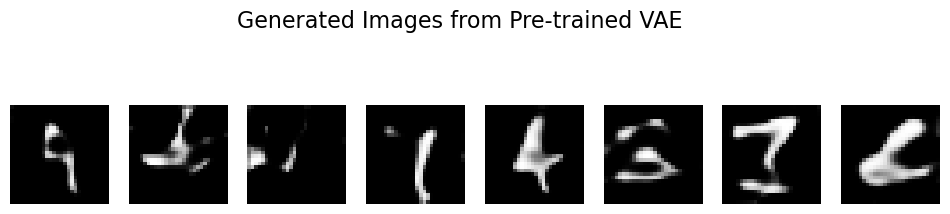

In [43]:
# Plot Generated Images
plt.figure(figsize=(12, 3))
for i in range(num_images):
    plt.subplot(1, num_images, i+1)
    plt.imshow(generated_images[i], cmap='gray')
    plt.axis('off')

plt.suptitle("Generated Images from Pre-trained VAE", fontsize=16)
plt.show()

### Generating New Images from Random Latent Vectors

This demonstrates the generative capability of VAEs:

**How it works:**
1. Sample random vectors from N(0,1) distribution
2. Use reparameterization trick to create valid latent points
3. Pass through decoder to generate images

**What you should see:**
- Recognizable digit-like shapes (if trained well)
- Variety of styles and forms
- Occasional "hallucinations" or blends between digits

**Quality indicators:**
- Clear, sharp digits = good latent space structure
- Blurry or nonsensical images = needs more training or better architecture

# Part 6 Examining the trained model Latent-Space

The latent space is where the magic happens—it's the compressed representation the VAE learns.

**Why explore it?**
- Understand what the model has learned
- Visualize how digits are organized in the compressed space
- Identify patterns, clusters, and relationships between digits
- Detect anomalies (images that don't fit the learned distribution)

**What we'll do:**
1. Encode all test images into latent space
2. Compute reconstruction losses
3. Visualize loss distribution
4. Project high-dimensional latent space to 3D for visualization
5. Find the most informative dimensions

## Part 6.1 Make sure our model is in evaluation mode

In [44]:
# Ensure model is in evaluation mode
vae.eval()

VAE(
  (encoder): Encoder(
    (conv0): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv1): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (bn1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(4, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (bn2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc1): Linear(in_features=392, out_features=128, bias=True)
    (fc_mu): Linear(in_features=128, out_features=16, bias=True)
    (fc_logvar): Linear(in_features=128, out_features=16, bias=True)
  )
  (decoder): Decoder(
    (fc1): Linear(in_features=16, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=392, bias=True)
    (deconv0): Conv2d(8, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn3): Bat

## Part 6.2 Losses from an anomalous image

Total loss: 1.650180e+02, Recon (sum): 1.361147e+02, MSE per-pixel: 1.736157e-01


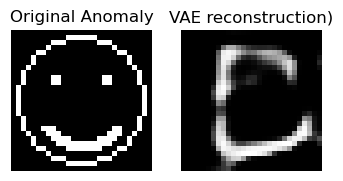

(165.0180206298828, 136.1147003173828, 0.1736156940460205)

In [55]:
# Anomaly Detection on a Single Image
anomaly_loss = 0.0

def vae_reconstruction_error(image_path, vae):

    # Load & preprocess (match training preprocessing: single-channel 28x28, values in [0,1])
    img = Image.open(image_path).convert('L').resize((28, 28))
    img_np = np.array(img).astype(np.float32) / 255.0
    x = torch.from_numpy(img_np).unsqueeze(0).unsqueeze(0).to(device)  # (1,1,28,28)


    with torch.no_grad():
        x_recon, mu, logvar =vae(x)
        mse_per_pixel = F.mse_loss(x_recon,x, reduction='mean')
        recon_loss =x.numel() * mse_per_pixel
        kl_loss =-0.5*torch.sum(1+logvar-mu.pow(2)-logvar.exp())
        total_loss = recon_loss +kl_loss

    # Print in scientific (SI) notation
    print(f"Total loss: {total_loss.item():.6e}, Recon (sum): {recon_loss.item():.6e}, MSE per-pixel: {mse_per_pixel.item():.6e}")

    # Plot the original and reconstructed images side by side
    plt.figure(figsize=(4, 2))

    plt.subplot(1,2,1)
    plt.title('Original Anomaly')
    plt.imshow(x.squeeze().cpu(), cmap='gray')
    plt.axis('off')

    plt.subplot(1, 2,2)
    plt.title('VAE reconstruction)')
    plt.imshow(x_recon.squeeze().cpu(),cmap='gray')
    plt.axis('off')
    plt.show()

    # Make sure the loss is stored for this image
    global anomaly_loss
    anomaly_loss = total_loss.item()

    return total_loss.item(), recon_loss.item(), mse_per_pixel.item()

vae_reconstruction_error('smiley_28x28_inverted.png', vae)


## Part 6.3 Iterate over the training and/or test dataset and collect the full distribution of individual latent vectors & losses

In [56]:
# We need to populate these lists with the latent vectors and losses from the models for the test and train datasets

# Collect latent representations and labels
train_latent_vectors = []
test_latent_vectors = []
train_labels = []
test_labels = []
train_all_losses = []
test_all_losses = []

In [57]:
with torch.no_grad():
    for batch, labels in train_loader:
        for x, y in zip(batch, labels):
            # This time we want to track which number ended up where in the latent-space
            x = x.to(device).unsqueeze(0)

            x_recon, mu , logvar =vae(x)

            z =mu

            img_loss = F.mse_loss(x_recon,x,reduction='mean')

            train_all_losses.append(img_loss.item())

            train_latent_vectors.append(z.cpu().numpy())
            train_labels.append(y.numpy())

    for batch, labels in test_loader:
        for x, y in zip(batch, labels):
            # This time we want to track which number ended up where in the latent-space
            x = x.to(device).unsqueeze(0)

            x_recon, mu , logvar =vae(x)

            z =mu

            img_loss = F.mse_loss(x_recon,x,reduction='mean')
            test_all_losses.append(img_loss.item())

            # Store the vectors and labels for plotting
            test_latent_vectors.append(z.cpu().numpy())
            test_labels.append(y.numpy())


In [58]:
print(len(train_all_losses), len(test_all_losses))


54000 10000


### Anomaly Detection with VAE Reconstruction Loss

This function demonstrates using the VAE for anomaly detection:

**Core idea:**
- Train VAE on normal data (MNIST digits)
- Normal images → low reconstruction loss
- Anomalies (non-digits) → high reconstruction loss

**How the function works:**
1. Load and preprocess the test image (resize to 28×28, normalize)
2. Pass through encoder → decoder to reconstruct
3. Compute reconstruction loss
4. Compare to distribution of losses from normal training data

**Applications:**
- **Manufacturing:** Detect defective products
- **Medical imaging:** Flag unusual scans
- **Fraud detection:** Identify suspicious transactions
- **Quality control:** Find outliers in datasets

**Key metrics:**
- `total_loss`: Combined reconstruction + KL divergence
- `recon_loss`: How different is reconstruction from input
- `mse_per_pixel`: Average squared error per pixel (easier to interpret)

**Interpretation:**
- Loss >> typical MNIST loss → strong anomaly
- Loss ≈ typical MNIST loss → possibly normal or similar to training data

## Part 6.4 Plot the distribution of per-image losses

In [66]:
print(anomaly_loss)

165.0180206298828


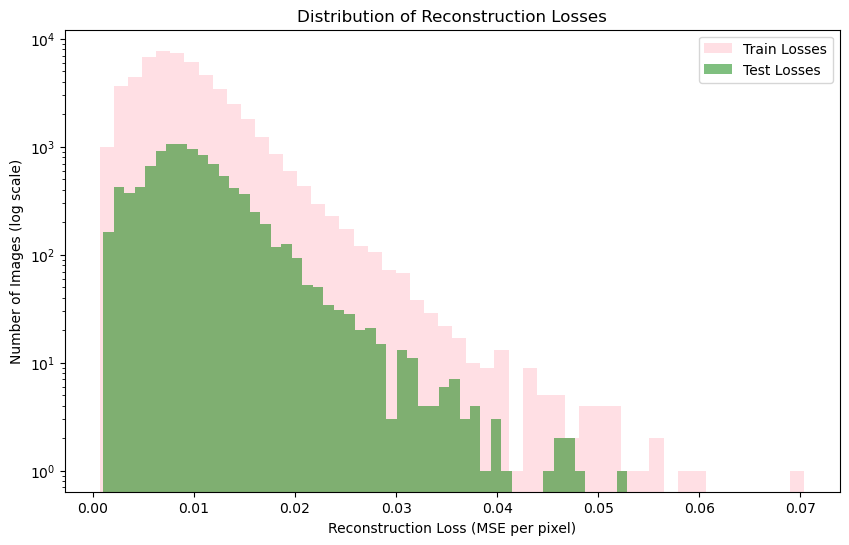

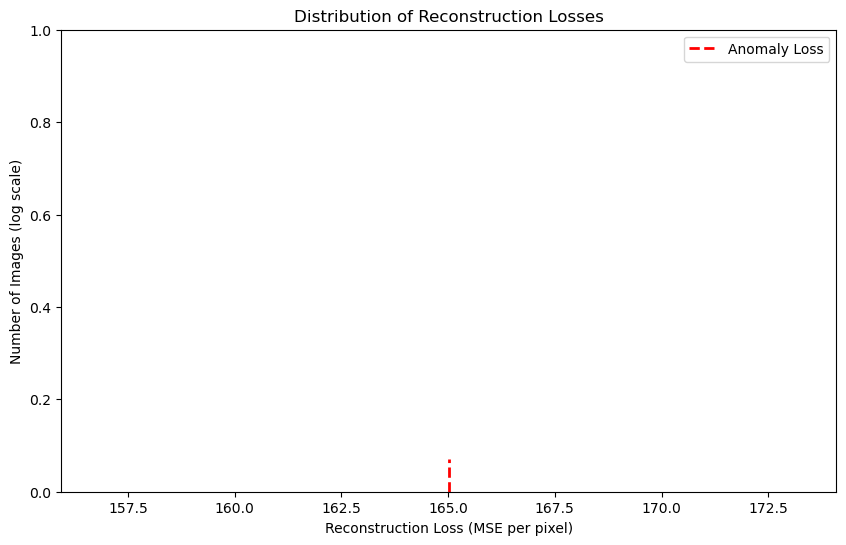

In [81]:
# Let's plot the distribution of losses for the whole test dataset,
# and compare it to the total loss for the anomaly (the smiley face image).
# Plot a histogram of train_all_losses and test_all_losses on the same figure, in two different colors, using plt.hist
#     It's helpful to use a log scale.
# Plot a red vertical line at the location of the total loss for the anomaly, using plt.axvline

plt.figure(figsize=(10,6))

plt.hist(train_all_losses, bins=50, alpha=0.5, label='Train Losses', color='pink', log=True)
plt.hist(test_all_losses, bins=50, alpha=0.5, label='Test Losses', color='green', log=True)

#plt.axvline(anomaly_loss,ymin=0,ymax=max(max(train_all_losses),max(test_all_losses)),color='red', linestyle='--', linewidth=2, label='Anomaly Loss')

plt.xlabel('Reconstruction Loss (MSE per pixel)')
plt.ylabel('Number of Images (log scale)')
plt.title('Distribution of Reconstruction Losses')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))

plt.axvline(anomaly_loss,ymin=0,ymax=max(max(train_all_losses),max(test_all_losses)),color='red', linestyle='--', linewidth=2, label='Anomaly Loss')

plt.xlabel('Reconstruction Loss (MSE per pixel)')
plt.ylabel('Number of Images (log scale)')
plt.title('Distribution of Reconstruction Losses')
plt.legend()
plt.show()

### Reconstruction Loss Distribution

This histogram shows how well the VAE reconstructs different test images:

**Interpreting the distribution:**
- **Narrow peak at low values:** Most images reconstruct well (good model)
- **Wide spread:** High variance in reconstruction quality
- **Long tail to the right:** Some images are much harder to reconstruct

**The red line (anomaly):**
- Shows where a non-MNIST image (e.g., smiley face) falls
- Far right of distribution → clearly an outlier/anomaly
- Near the peak → model might confuse it with actual digits

**Applications:**
- **Anomaly detection:** Images with high loss are unusual/out-of-distribution
- **Quality control:** Identify poorly performing subsets
- **Data validation:** Find mislabeled or corrupted examples

### What is the model doing?

Although our model is always a black-box in terms of training it's sometimes useful to ask what the trained model is actually doing with the input data.

This can help inform better model design and hopefully give better performance.

Since this model is designed with an initial `Conv2d` layer which takes the input data and parses it before letting the rest of the model analyze what's going on, it's probably interesting to see what features it highlights/removes from a random image before encoding/decoding.

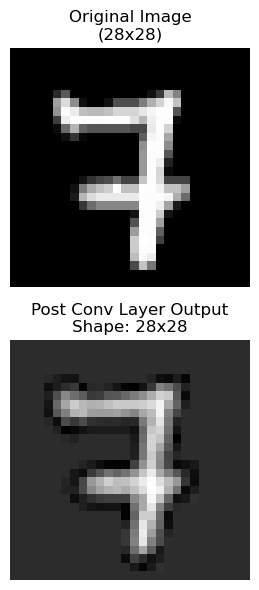

In [60]:
# Function to Apply Convolution with Different Configs
def apply_conv(input_image):
    conv = vae.encoder.conv0
    output = conv(input_image)
    return output

# Plot Input Image
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.imshow(image.squeeze(), cmap='gray')
plt.title(f"Original Image\n(28x28)")
plt.axis('off')

output = apply_conv(input_image.to(device))
output_shape = output.shape  # Shape: (1, 1, H_out, W_out)

plt.subplot(2, 1, 2)
plt.imshow(torch.sqrt(output**2).detach().squeeze().cpu(), cmap='gray')
plt.title(f"Post Conv Layer Output\nShape: {output_shape[2]}x{output_shape[3]}")
plt.axis('off')

plt.tight_layout()
plt.show()

## Part 6.5: 3D Latent Space Visualization

This visualization projects the high-dimensional latent space (e.g., 32D) down to 3D for visualization:

**Finding the most informative dimensions:**
- Computes variance across each latent dimension
- Selects the top 3 dimensions with highest variance
- These capture the most variation in the data

**All 6 permutations (orderings) of the 3 dimensions:**
- Shows the latent space from different "angles"
- Helps identify clusters, overlaps, and structure
- Each subplot uses the same 3 dimensions but in different axis assignments

**What good separation looks like:**
- Distinct clusters for different digit classes
- Minimal overlap between clusters
- Smooth transitions between similar digits (e.g., 4 and 9)

**What to watch for:**
- Overlapping clusters → model struggles to distinguish those digits
- Scattered points → poorly structured latent space
- Linear arrangements → model using dimensions efficiently

In [76]:
# Convert lists to arrays
latent_vectors = np.concatenate(test_latent_vectors, axis=0)
labels = np.array(test_labels)
print("Latent Vectors Shape:", latent_vectors.shape)
print("Labels Shape:", labels.shape)

Latent Vectors Shape: (10000, 16)
Labels Shape: (10000,)


Top 3 latent dimensions with widest spread: [4 2 0]


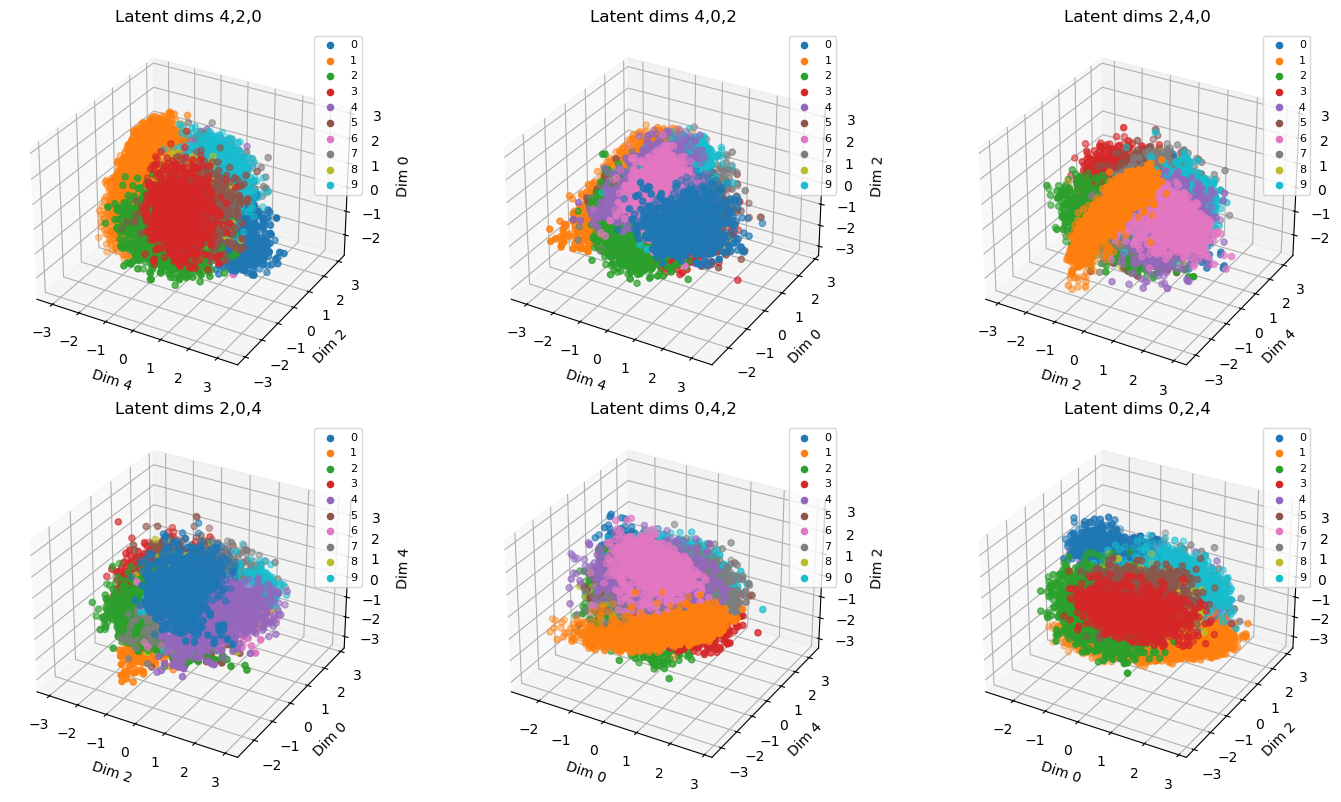

In [ ]:
variances = latent_vectors.var(axis=0)
top3_dims =np.argsort(variances)[-3:][::-1]

print("Top 3 latent dimensions with widest spread:", top3_dims)

# Plot all ordered 3-axis permutations (6 views)
perms = list(permutations(top3_dims, 3))  # 6 permutations

cols = 3
rows = (len(perms) + cols - 1) // cols
fig = plt.figure(figsize=(cols * 5, rows * 4))

for i, (d0, d1, d2) in enumerate(perms):
    ax= fig.add_subplot(rows,cols,i+1,projection='3d')

    for no in np.unique(labels):
        idx = labels ==no
        ax.scatter(latent_vectors[idx,d0],latent_vectors[idx,d1],latent_vectors[idx,d2],label=str(no))
    ax.set_xlabel(f'Dim {d0}')
    ax.set_ylabel(f'Dim {d1}')
    ax.set_zlabel(f'Dim {d2}')
    ax.set_title(f'Latent dims {d0},{d1},{d2}')
    ax.legend(fontsize=8, loc='upper right')
   
    
plt.tight_layout()
plt.show()